In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-20 19:35:39.730205: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-20 19:35:43.352833: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-20 19:35:43.537650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-20 19:35:43.537714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-20 19:35:43.582273: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-20 19:35:43.582317: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-20 19:35:43.602615: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [4]:
R = Runner(verbose=True, classifier='kunetplus2d')

*** GP2 ***
Working directory: /tmp/tmp85uxrbokGP2
Verbose mode active!


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "unet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
unet_down0_0 (Conv2D)        (None, 512, 512, 32)      288       
_________________________________________________________________
unet_down0_0_bn (BatchNormal (None, 512, 512, 32)      128       
_________________________________________________________________
unet_down0_0_activation (ReL (None, 512, 512, 32)      0         
_________________________________________________________________
unet_down0_1 (Conv2D)        (None, 512, 512, 32)      9216      
_________________________________________________________________
unet_down0_1_bn (BatchNormal (None, 512, 512, 32)      128       
_________________________________________________________________
unet_down0_1_activation (ReL (None, 512, 512, 32)      0

2023-04-20 19:35:52.438699: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 19:35:52.443065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-20 19:35:52.451324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-04-20 19:35:52.452183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-20 19:35:53.717338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images.shape

(10000, 512, 512, 1)

In [7]:
masks.shape

(10000, 512, 512, 1)

In [8]:
print(images.max())

255


In [9]:
print(images.min())

0


In [10]:
print(masks.max())

True


In [11]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [12]:
R.setup_data(images, masks, dataset_size=10000, weights=weights)

Weights OK!


In [13]:
RUNS = 5

In [14]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-20 19:37:59.249427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-20 19:37:59.271054: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-20 19:38:02.352630: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-20 19:38:03.489335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-20 19:38:05.015815: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-20 19:38:05.015841: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-20 19:38:05.016547: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-20 19:38:05.037309: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-20 19:38:06.378555: I tensorflow/stream_exec

8/8 [==============================] - 59s 4s/step - loss: 0.6460 - dice_coef: 0.1330 - val_loss: 0.6909 - val_dice_coef: 0.1629


2023-04-20 19:39:01.116708: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 0.6457 - dice_coef: 0.1332 - val_loss: 0.6885 - val_dice_coef: 0.1628
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 0.6460 - dice_coef: 0.1331 - val_loss: 0.6864 - val_dice_coef: 0.1627
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 0.6459 - dice_coef: 0.1332 - val_loss: 0.6846 - val_dice_coef: 0.1627
Model saved to: /tmp/tmp85uxrbokGP2/kunetplus2d_0kunetplus2d_model
History saved to: /tmp/tmp85uxrbokGP2/kunetplus2d_history_0.pkl
Testing the classifier...
Model saved to /tmp/tmp85uxrbokGP2/cnnd_0.model
History saved to /tmp/tmp85uxrbokGP2/cnnd_history_0.pickle
Testing the discriminator...
19/19 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Found 318 machine labels.
Machine labels [  1   5   6   9  13  14  15  18  19  20  24  26  28  29  32  34  36  37
  38  39  40  41  43  44  46  47  48  49  51  52  54  56  58  60  65  66
  67 

Removed: 106 Filled: 106
TOOK 293.86730098724365 seconds
***
RUN: 1
Epoch 1/100
10/10 [==============================] - 22s 2s/step - loss: 0.6453 - dice_coef: 0.1342 - val_loss: 0.6827 - val_dice_coef: 0.1626
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 0.6452 - dice_coef: 0.1335 - val_loss: 0.6811 - val_dice_coef: 0.1626
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 0.6454 - dice_coef: 0.1335 - val_loss: 0.6797 - val_dice_coef: 0.1625
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 0.6451 - dice_coef: 0.1335 - val_loss: 0.6787 - val_dice_coef: 0.1625
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 0.6454 - dice_coef: 0.1331 - val_loss: 0.6777 - val_dice_coef: 0.1625
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 0.6454 - dice_coef: 0.1337 - val_loss: 0.6770 - val_dice_coef: 0.1624
Model saved to: /tmp/tmp85uxrbokGP2/kunetplus2d_1kunetplus2d_model
History

In [15]:
R.classifier_scores

[[0.6845703125, 0.16162945330142975], [0.6769505143165588, 0.1613466888666153]]

In [16]:
R.discriminator_scores

[[0.0, 1.0], [5841.759765625, 0.49666666984558105]]

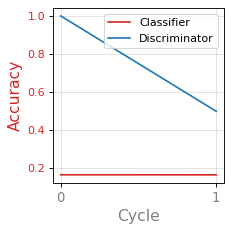

In [17]:
R.plot()